# Fixed experimental parameters

In [1]:
root = "/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit"

def print_fixed_parameters(config):
    ! $root/bin/jq 'del(.makeRegions.minRepeatPeriod)' $config
    
print_fixed_parameters('data/minRepeatPeriod=0/config.json')

{
  "makeRegions": {
    "slop": "250",
    "minCoverage": "0",
    "maxCoverage": "200",
    "maxRegionLength": "100000",
    "minRepeatLength": "100",
    "functionalRegions": "none",
    "genomeBuild": "hg38",
    "overlappedFunctionalRegions": "false",
    "ucscTable": "simpleRepeat"
  },
  "makeCalls": {
    "singleBaseMatchReward": "10",
    "singleBaseMismatchPenalty": "12",
    "gapOpenPenalties": "6,26",
    "gapExtensionPenalties": "1,0",
    "minUnitigMappingQuality": "1"
  },
  "filterCalls": {
    "maxIntraClusterDistance": "500",
    "minSVSize": "50",
    "minUnitigMappingQuality": "0",
    "minUnitigBlockLength": "25",
    "svtype": "DEL"
  },
  "general": {
    "reference": "/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/reference/GRCh38_full_analysis_set_plus_decoy_hla",
    "numberThreads": "16",
    "alignments": "/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/illumina_crams/ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/hgsv_sv_discovery/da

# Performance in VNTRs

In [2]:
import json
import pandas as pd 

def add_performance(table, truvari_data, tool, calls):
    table.append([
        tool,
        calls,
        truvari_data['TP-base'],
        truvari_data['FN'],
        truvari_data['FP'], 
        truvari_data['TP-base'] + truvari_data['FN']
    ])
    
def create_performance_table(output):
    table = []
    with open('{}/truvari-pacbio-manta/summary.txt'.format(output)) as json_file:
        add_performance(table, json.load(json_file), 'manta', 'all')    
    with open('{}/truvari-pacbio-trfermikit/summary.txt'.format(output)) as json_file:
        add_performance(table, json.load(json_file), 'trfermikit', 'all')
    with open('{}/truvari-pacbio-trfermikit.unitigSupport/summary.txt'.format(output)) as json_file:
        add_performance(table, json.load(json_file), 'trfermikit', 'unitigSupport')
    with open('{}/truvari-pacbio-trfermikit.unitigSupport.thinned/summary.txt'.format(output)) as json_file:
        add_performance(table, json.load(json_file), 'trfermikit', 'unitigSupport.thinned')
    return table 

def visualize_performance_table(output):
    from IPython.display import HTML
    columns = ['tool', 'calls', 'TP', 'FN', 'FP', '# real events']
    df_ = pd.DataFrame(
        create_performance_table(output), 
        columns=columns
    )
    return HTML(df_.to_html(index=False))

In [3]:
visualize_performance_table('data/minRepeatPeriod=0')

tool,calls,TP,FN,FP,# real events
manta,all,1218,3659,1127,4877
trfermikit,all,1944,2933,7653,4877
trfermikit,unitigSupport,1720,3157,2794,4877
trfermikit,unitigSupport.thinned,1607,3270,1868,4877


In [4]:
visualize_performance_table('data/minRepeatPeriod=6')

tool,calls,TP,FN,FP,# real events
manta,all,1077,3501,1020,4578
trfermikit,all,1784,2794,6854,4578
trfermikit,unitigSupport,1580,2998,2583,4578
trfermikit,unitigSupport.thinned,1470,3108,1715,4578


There are a number of observations: 

* The tables report poor performance of `manta` in tandem-repeat regions. This has been found by others; see panels B and C at https://www.nature.com/articles/s41467-019-11146-4/figures/2 

* After filtering `trfermikit` calls (the "calls" column of the tables), `trfermikit` performs comparably to `manta`.

* The vast majority of the events that occur in tandem repeats, occur in tandem repeats with repeat units larger than 6bp. **We will confine future analyses to VNTRs (period > 6bp)**, and leave the discovery of variants in STRs to established STR callers. 

## `trfermikit` picks up a significant number of calls missed by `manta` 

`trfermikit` picks up the majority of `manta` TPs while also discovering a significant number of pacbio events that `manta` missed:  

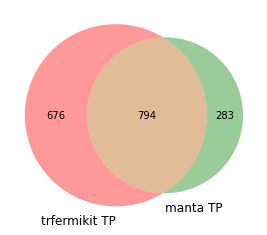

In [5]:
def list_to_value(list_): 
    value, = list_
    return int(value)

overlap_fraction = 0.9

def tr_fermikit_TP_intersect_manta(manta_callset, output): 
    list_ = ! $root/bin/bedtools intersect -u -wb -f $overlap_fraction -r \
      -a $output/truvari-pacbio-manta/$manta_callset".vcf" \
      -b $output/truvari-pacbio-trfermikit.unitigSupport.thinned/tp-base.vcf \
      | wc -l 
    return list_to_value(list_)

def tr_fermikit_TP_less_manta(manta_callset, output):
    list_ = ! $root/bin/bedtools subtract -A -f $overlap_fraction -r \
      -a $output/truvari-pacbio-trfermikit.unitigSupport.thinned/tp-base.vcf \
      -b $output/truvari-pacbio-manta/$manta_callset".vcf" \
      | wc -l
    return list_to_value(list_)

def manta_less_tr_fermikit_TP(manta_callset, output):
    list_ = ! $root/bin/bedtools subtract -A -f $overlap_fraction -r \
      -a $output/truvari-pacbio-manta/$manta_callset".vcf" \
      -b $output/truvari-pacbio-trfermikit.unitigSupport.thinned/tp-base.vcf \
    | wc -l 
    return list_to_value(list_)

def check(manta_callset): 
    if manta_callset != 'fn' and manta_callset != 'tp-base': 
        raise Exception
    else: 
        pass
        
# https://towardsdatascience.com/how-to-create-and-beautify-venn-diagrams-in-python-331129bd4ed3
from matplotlib_venn import venn2

def tr_fermikit_manta_venn2(
        manta_callset, 
        manta_label,
        output='data/minRepeatPeriod=6'
    ):
    check(manta_callset)
    vd = venn2(
        subsets = {
            '10': tr_fermikit_TP_less_manta(manta_callset, output),
            '11': tr_fermikit_TP_intersect_manta(manta_callset, output),
            '01': manta_less_tr_fermikit_TP(manta_callset, output)
        }, 
        set_labels = ('trfermikit TP', manta_label))
    return vd

_ = tr_fermikit_manta_venn2(manta_callset='tp-base', manta_label='manta TP')

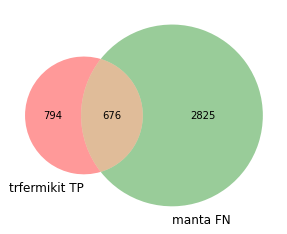

In [6]:
_ = tr_fermikit_manta_venn2(manta_callset='fn', manta_label='manta FN')